In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, 'code')

In [3]:
import json
from functools import reduce

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

from easydict import EasyDict as edict


from mac import MACNetwork
from utils import IntermediateLayerGetter, load_vocab
from datasets import GQADataset, collate_fn_gqa, ClevrDataset, collate_fn
from visualize_attentions2 import plot_word_img_attn_lobs, plot_word_img_attn_objs, idxs_to_question, get_image

In [4]:
model_dir = 'data/5_256_3layers_faster/'

In [5]:
with open(os.path.join(model_dir, 'cfg.json'), 'r') as f:
    cfg = json.load(f)

In [12]:
from config import __C, _merge_a_into_b

cfg = edict(cfg)
_merge_a_into_b(cfg, __C)
cfg = __C

print(json.dumps(cfg.model, indent=4))

logcomet is not a valid config key
cfg_file is not a valid config key
exp_name is not a valid config key
manualSeed is not a valid config key
{
    "d_model": 256,
    "n_instructions": 5,
    "transformer_nlayers": 3,
    "transformer_dropout": 0.2,
    "transformer_heads": 4,
    "PE_dropout": 0.1,
    "n_filmblocks": 3,
    "in_channels": 2048,
    "cnn_dim": 256,
    "n_operations": 1,
    "operation_linear": false
}


In [24]:
data_dir = '/Users/sebamenabar/Documents/datasets/GQA/data'
cfg.DATASET.DATA_DIR = data_dir

dataset = cfg.DATASET.DATASET
cfg.DATASET.DATASET = dataset

# if dataset == 'clevr':
#     dataset_root = '/storage1/datasets/CLEVR_v1.0/'
# #     data_dir = os.path.join(dataset_root, 'data')
#     data_dir = os.path.join(dataset_root, 'features')
#     images_dir = os.path.join(dataset_root, 'images')
if dataset == 'gqa':
    dataset_root = '/Users/sebamenabar/Documents/datasets/GQA'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
cfg.DATASET.DATA_DIR = data_dir

In [25]:
split = 'val'
if cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif cfg.DATASET.DATASET == 'clevr':
    ds = ClevrDataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(dataset_root, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
    
vocab = load_vocab(cfg)
reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']
num_answers = len(reverse_answer_dic)

In [18]:
from filmant import load_filmant

In [131]:
model = load_filmant(vocab, cfg)
state = torch.load('data/5_256_3layers_faster/Model/model_checkpoint_000075.pth', map_location='cpu')
model.load_state_dict(state['model'])
model.eval()
return_layers = {
    'kb_attn_idty': 'kb_attn',
    'res_block_idty' : 'res_block_idty',
    'features_idty' : 'features_idty',
    'question_to_instruction.transformer.layers.0.self_attn' : 'cw_attn',
    'question_to_instruction.transformer.layers.1.self_attn' : 'cw_attn',
    'question_to_instruction.transformer.layers.2.self_attn' : 'cw_attn',
    'visualTransformer.layers.0.self_attn' : 'vis_attn',
    'visualTransformer.layers.1.self_attn' : 'vis_attn',
    'visualTransformer.layers.2.self_attn' : 'vis_attn',
    'reasoningTransformer.layers.0.self_attn' : 'res_attn',
    'reasoningTransformer.layers.1.self_attn' : 'res_attn',
    'reasoningTransformer.layers.2.self_attn' : 'res_attn',

}
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

num_steps = cfg.model.n_instructions

In [28]:
model

StepFilm(
  (question_to_instruction): QuestionToInstruction(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=T

In [197]:
import pandas as pd
import seaborn as sns
from visualize_attentions import plot_word_img_attn

In [312]:
avg_transformer_layers_outputs(mid_outputs['res_attn'])[-1]

tensor([0.1583, 0.1536, 0.1566, 0.1572, 0.1559, 0.2184])

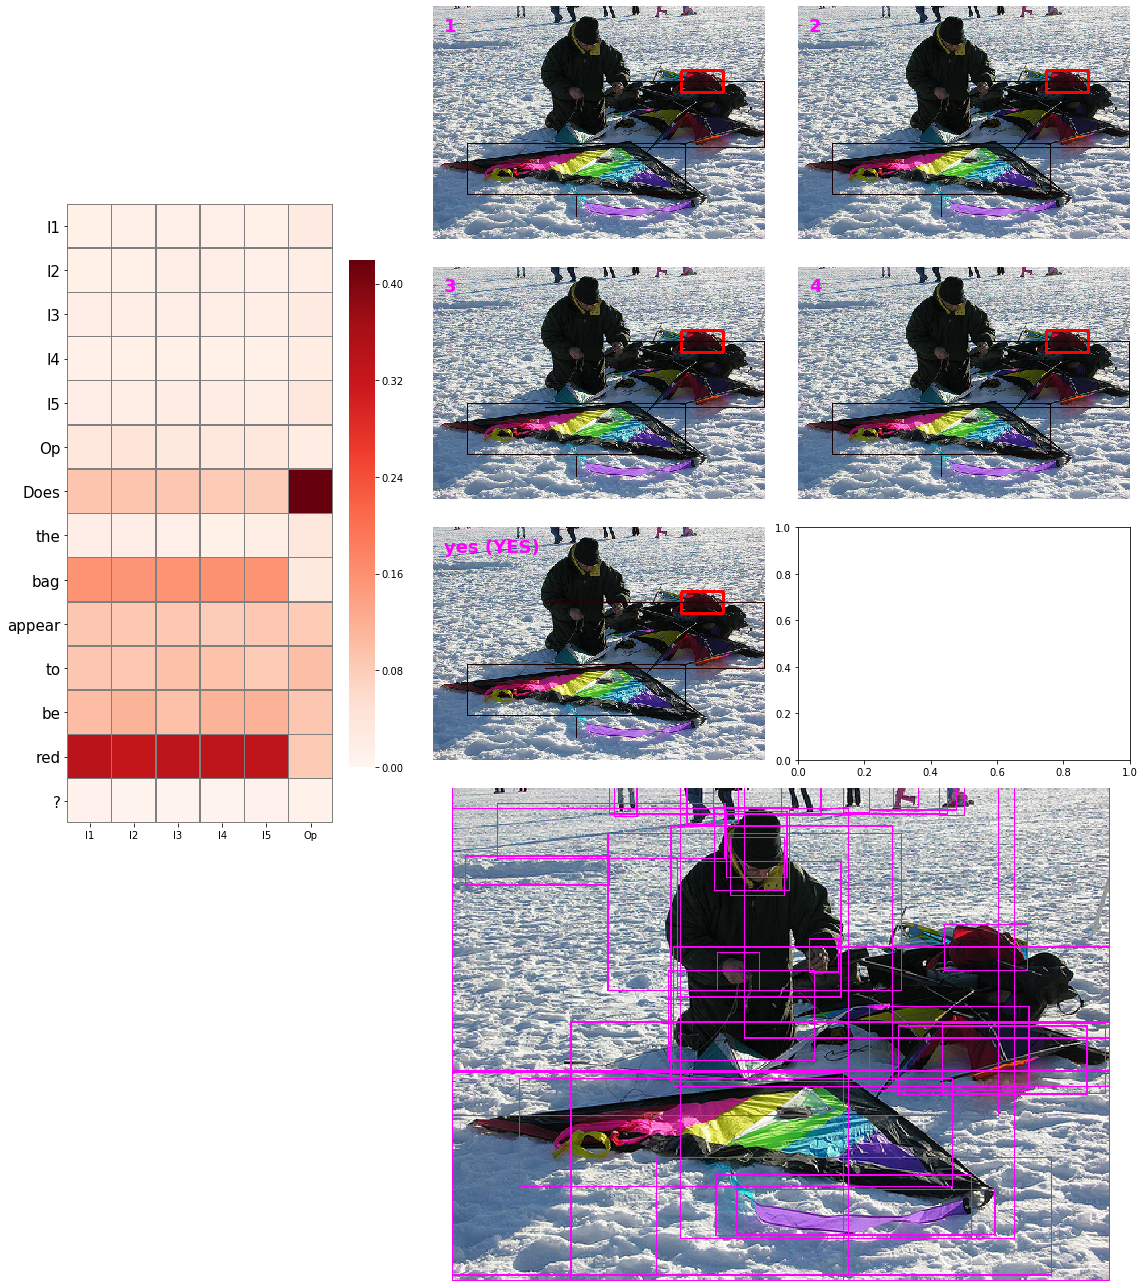

In [302]:
q_index = 5

if dataset == 'gqa':
    b = collate_fn_gqa([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    
    imgid, question, answer, group, questionid = ds.data[q_index]
    img_info = ds.spatial_info[imgid]
    num_gt_objs = img_info['objectsNum']
    
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])
    
with torch.no_grad():
    mid_outputs, output = mid_getter(b['question'], b['question_length'], b['image'], b['bbox'])

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]
bboxes = b['bbox'][0].numpy()
# num_gt_objs = b['image'][1].item()

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

reduction = avg_transformer_layers_outputs
# reduction = reduce_transformer_attn

vis_attns = reduction(mid_outputs['vis_attn'])
obj_vis_attns = vis_attns[-cfg.model.n_instructions:,:num_gt_objs]

plot_word_img_attn(
    cw_attns=reduction(mid_outputs['cw_attn']),
    bboxes=bboxes,
    obj_vis_attns=obj_vis_attns,
    num_steps=num_steps,
    words=tokenized_questions,
    images_root=images_dir,
    image_filename=image_filename,
    pred=pred,
    gt=gt,
    model_cfg=cfg.model,
    vis='attn',
    num_gt_objs=num_gt_objs,
)

In [257]:
vis_attns = avg_transformer_layers_outputs(mid_outputs['vis_attn'])

In [286]:
import cv2
import math
import matplotlib.gridspec as gridspec

from visualize_attentions import setlabel

In [265]:
images_root = images_dir

In [271]:
vis_attns[-cfg.model.n_instructions:,:num_gt_objs].size()

torch.Size([5, 36])

In [272]:
objs_vis_attns = vis_attns[-cfg.model.n_instructions:,:num_gt_objs]

In [280]:
bboxes = b['bbox'][0].numpy()

In [276]:
def interpolate(val, x_low, x_high):
    return (val - x_low) / (x_high - x_low)

In [ ]:
gt_obbs_attn_i

In [283]:
top_left, bottom_right

([51, 221], [380, 303])

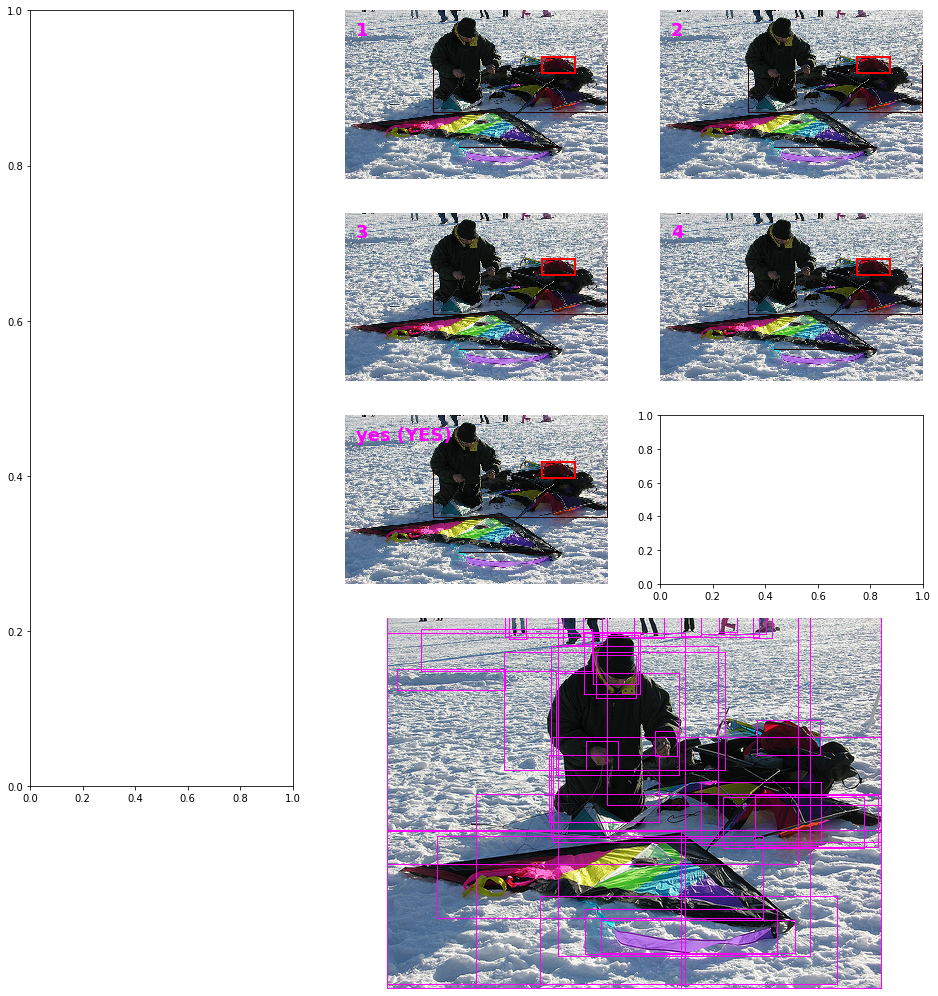

In [298]:
fig = plt.figure(figsize=(16, 2 * (num_steps + num_steps // 2) + 4))

g0 = gridspec.GridSpec(math.ceil(num_steps / 2) + 2, 3, figure=fig)

ax_raw_image = fig.add_subplot(g0[-2:, 1:])
image_path = os.path.join(images_root, image_filename)
img = np.array(Image.open(image_path).convert('RGB'))
ax_raw_image.imshow(img)
ax_raw_image.set_axis_off()
# ax_raw_image.set_aspect("auto")

ax_table = fig.add_subplot(g0[:-1, 0])
ax_images = []
for i in range(math.ceil(num_steps / 2)):
    ax_images.append(fig.add_subplot(g0[i, 1]))
    ax_images.append(fig.add_subplot(g0[i, 2]))
    

img_ref = img.copy()
for j in range(num_gt_objs):
    box_abs_coords_j = bboxes[j]
    top_left, bottom_right = box_abs_coords_j[:2].astype(np.int64).tolist(), box_abs_coords_j[2:].astype(np.int64).tolist()
    img_ref = cv2.rectangle(img_ref, tuple(top_left), tuple(bottom_right), (255, 0, 255), 1)
ax_raw_image.imshow(img_ref)
ax_raw_image.set_axis_off()
    
for ni in range(cfg.model.n_instructions):
    img_i = img.copy()
    ax_i = ax_images[ni]

    gt_obbs_attn_i = objs_vis_attns[ni]
    low, high = gt_obbs_attn_i.min().item(), gt_obbs_attn_i.max().item()
    top = gt_obbs_attn_i.topk(4).values[-1].item()
    for j in range(num_gt_objs):
        box_attn_ij = gt_obbs_attn_i[j].item()
        if box_attn_ij >= top:
            box_abs_coords_j = bboxes[j] # * (w, h, w, h)
            top_left, bottom_right = box_abs_coords_j[:2].astype(np.int64).tolist(), box_abs_coords_j[2:].astype(np.int64).tolist()

            score = interpolate(box_attn_ij, low, high)
            c_intensity = 255 * score
            linewidth = (4 * score)
            
            img_i = cv2.rectangle(img_i, tuple(top_left), tuple(bottom_right), (math.ceil(c_intensity), 0, 0), int(round(linewidth)))

            # img_i = cv2.rectangle(img_i, tuple(top_left), tuple(bottom_right), 1, 1)

    ax_i.imshow(img_i)
    if ni == (num_steps - 1):
        setlabel(ax_i, f'{pred} ({gt.upper()})')
    else:
        setlabel(ax_i, str(ni + 1))

    ax_i.set_axis_off()
    ax_i.set_aspect("auto")


In [210]:
def reduce_transformer_attn(attn_outputs):
    attns = [attn[1][0] for attn in attn_outputs]
    
    return reduce(lambda x, y: torch.matmul(x, y), attns)

In [213]:
def avg_transformer_layers_outputs(attn_outputs):
    attns = [attn[1][0] for attn in attn_outputs]
    attns = sum(attns) / len(attns)
    
    return attns

In [41]:
b['bbox'].size()

torch.Size([1, 100, 4])

In [46]:
print(mid_outputs.keys())
print(mid_outputs['cw_attn'][0][0].size())
print(mid_outputs['vis_attn'][1][0][0].size())
print(mid_outputs['res_attn'][1][0][0].size())

odict_keys(['cw_attn', 'features_idty', 'vis_attn', 'res_attn'])
torch.Size([18, 1, 256])
torch.Size([1, 256])
torch.Size([1, 256])


In [49]:
cw_attns = [attn[1] for attn in mid_outputs['cw_attn']]
cw_attns = sum(cw_attns) / len(cw_attns)

In [54]:
cw_attns.sum(dim=2)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

In [249]:
def show_and_tell(q_index):
    # q_index = 3

    if dataset == 'gqa':
        if use_feats == 'spatial':
            gqa_collate_fn = collate_fn_gqa
        elif use_feats == 'objects':
            gqa_collate_fn = collate_fn_gqa_objs
        b = gqa_collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    elif dataset == 'clevr':
        b = collate_fn([ds[q_index]])
        image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])

    with torch.no_grad():
        mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'],)

    pred = vocab['answer_idx_to_token'][output.argmax().item()]
    gt = vocab['answer_idx_to_token'][b['answer'].item()]
    bboxes = b['image'][0][0, :, -4:]
    num_gt_objs = b['image'][1].item()

    tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

    fig = plot_word_img_attn_objs(
        mid_outputs,
        num_steps,
        tokenized_questions,
        images_dir,
        image_filename,
        pred,
        gt,
        bboxes=bboxes.numpy(),
        num_gt_objs=num_gt_objs,
        num_gt_lobs=num_gt_lobs,
    )
    
    cw_ax = fig.get_axes()[1]
    cw_ax.set_title('Question %d' % q_index)
    plt.tight_layout()
    plt.show()
    
    return fig

In [264]:
q_index = 6000

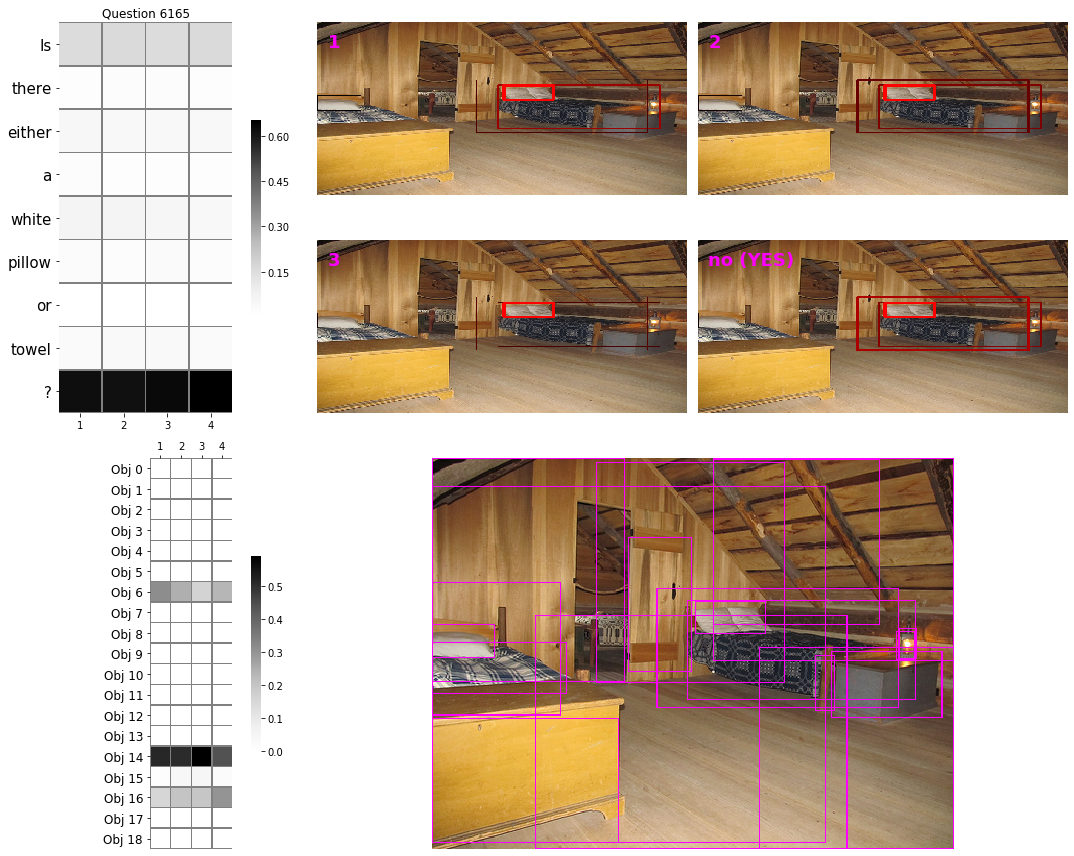

In [294]:
q_index += 11
# q_index = 10
fig = show_and_tell(q_index)